In [1]:
%pylab inline

import numpy as np

import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt

from scipy.stats import norm
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

np.random.seed(66)

Populating the interactive namespace from numpy and matplotlib


### Degeneracy between faint, widely-separated dipole and bright, close dipole:

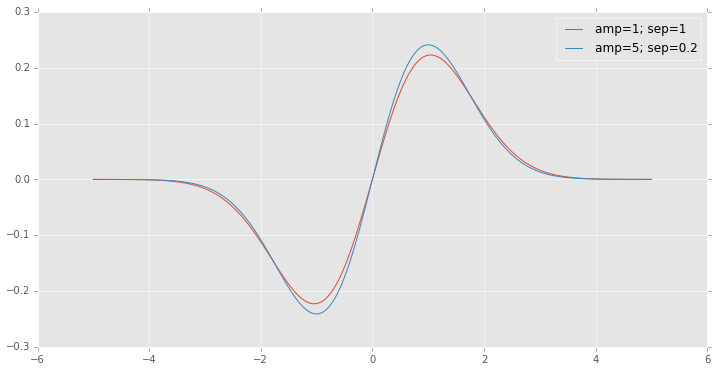

In [2]:
if True:
    x = np.arange(-5,5, 0.001)
    plt.plot(x, 1. * (norm.pdf(x, 0.5, 1) - norm.pdf(x, -0.5, 1)))   ## faint, distant diple
    plt.plot(x, 5. * (norm.pdf(x, 0.1, 1) - norm.pdf(x, -0.1, 1)))   ## bright, close dipole
    plt.legend(['amp=1; sep=1', 'amp=5; sep=0.2'])
    plt.show()

### In the below, set amp1=1.3, sep1=0.8, amp2=5.0, amp2=0.2 ...

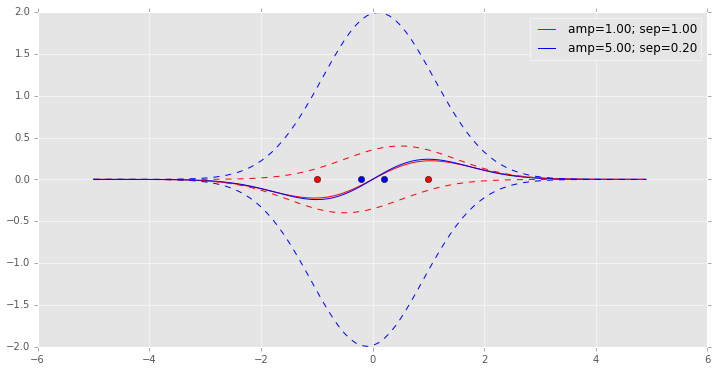

<function __main__.do_plot>

In [3]:
from ipywidgets import interact

def do_plot(amp1=1., sep1=1., amp2=5., sep2=0.2, show_components=True):
    x = np.arange(-5, 5, 0.1)
    plt.plot(x, amp1 * (norm.pdf(x, sep1/2., 1) - norm.pdf(x, -sep1/2., 1)), color='red')   ## faint, distant diple
    plt.plot(x, amp2 * (norm.pdf(x, sep2/2., 1) - norm.pdf(x, -sep2/2., 1)), color='blue')   ## bright, close dipole
    if show_components:
        plt.plot(x, amp1 * -norm.pdf(x, -sep1/2., 1), linestyle='dashed', color='red')
        plt.plot(x, amp1 *  norm.pdf(x,  sep1/2., 1), linestyle='dashed', color='red')
        plt.plot(x, amp2 * -norm.pdf(x, -sep2/2., 1), linestyle='dashed', color='blue')
        plt.plot(x, amp2 *  norm.pdf(x,  sep2/2., 1), linestyle='dashed', color='blue')
        
    plt.plot([-sep1, sep1], [0,0], 'ro')
    plt.plot([-sep2, sep2], [0,0], 'bo')
    plt.legend(['amp=%.2f; sep=%.2f' % (amp1, sep1), 'amp=%.2f; sep=%.2f' % (amp2, sep2)])
    plt.show()
    
##do_plot()

interact(do_plot, amp1=(0., 10.), sep1=(0., 2.), amp2=(0., 10.), sep2=(0., 2.), show_components=True)

### Try fitting it...

In [4]:
import lmfit

def gen_dipole2(x, amp1=1., sep1=1.):
    ypos = amp1 * norm.pdf(x,  sep1/2., 1)
    yneg = amp1 * norm.pdf(x, -sep1/2., 1)                  
    y = ypos - yneg
    return np.append(y, [ypos, yneg])

def gen_dipole(x, amp1=1., sep1=1.):
    #y = amp1 * (norm.pdf(x, -sep1/2., 1) - norm.pdf(x, sep1/2., 1))
    y = gen_dipole2(x, amp1, sep1)[:len(x)]
    return y

def fitDipole(ydata, xdata, amp1Start=3., sep1Start=2., fitFunc=gen_dipole, verbose=False):
    gmod = lmfit.Model(fitFunc, verbose=verbose)
    result = gmod.fit(ydata, x=xdata, amp1=amp1Start, sep1=sep1Start, verbose=verbose)

    if verbose: 
        print(result.fit_report(show_correl=False))
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    return result

 - Adding parameter "sep1"
 - Adding parameter "amp1"
[[Model]]
    Model(gen_dipole)
[[Fit Statistics]]
    # function evals   = 59
    # data points      = 40
    # variables        = 2
    chi-square         = 0.134
    reduced chi-square = 0.004
[[Variables]]
    sep1:   0.34564330 +/- 2.099320 (607.37%) (init= 1.5)
    amp1:   3.10751218 +/- 18.59272 (598.32%) (init= 1.5)

         99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 sep1:  -0.34564  -0.34564  -0.34564   0.34564  +0.90937  +1.41373  +1.85223
 amp1:  -2.53806  -2.41217  -2.18228   3.10751      +inf      +inf      +inf


/Users/dreiss/PYTHONUSERBASE/lib/python2.7/site-packages/lmfit/confidence.py:298: UserWarning: Warning, rel_change=9.92459602067e-06 < 0.01  at iteration 166 and prob(amp1=106.27691688) = 0.0646485372073 < max(sigmas).
  warn(errmsg)


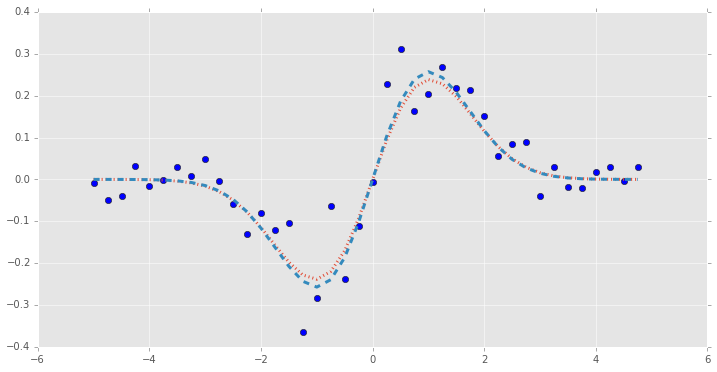

In [5]:
xdata = np.arange(-5, 5, 0.25)
ydataOrig = gen_dipole2(xdata, amp1=1.3, sep1=0.8)
ydataOrigNoisy = ydataOrig + np.random.normal(scale=np.abs(ydataOrig)/10.+0.02, size=ydataOrig.shape) ## save it for fitting below...
ydataOrigNoisy[:len(xdata)] = ydataOrigNoisy[len(xdata):len(xdata)*2] - ydataOrigNoisy[len(xdata)*2:]
ydata = ydataOrigNoisy[:len(xdata)] 

result = fitDipole(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole, verbose=True)
plt.plot(xdata, ydata, 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit, linewidth=3, linestyle='dashed')
plt.show()

/Users/dreiss/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


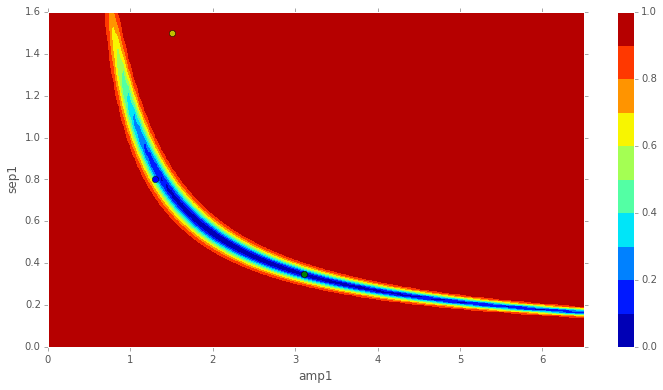

In [6]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, 
                                     limits=((0.,np.max([6.5,result.params['amp1'].value])), 
                                             (0., np.max([1.6,result.params['sep1'].value]))))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1')
plt.colorbar()
plt.ylabel('sep1')
plt.plot(1.3, 0.8, 'bo') ## input params
plt.plot(1.5, 1.5, 'yo') ## starting params
plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go')  ## fitted params

The F-test is used to compare our null model, which is the best fit we have found, with an alternate model, where one of the parameters is fixed to a specific value. The value is changed until the difference between $\chi^2_0$ and $\chi^2_{f}$ can’t be explained by the loss of a degree of freedom within a certain confidence.

$F(P_{fix},N-P) = \left(\frac{\chi^2_f}{\chi^2_{0}}-1\right)\frac{N-P}{P_{fix}}$

$N$ is the number of data-points, $P$ the number of parameter of the null model. $P_{fix}$ is the number of fixed parameters (or to be more clear, the difference of number of parameters between our null model and the alternate model).

### Try my idea of using image and template separately to constrain fit...

 - Adding parameter "sep1"
 - Adding parameter "amp1"
[[Model]]
    Model(gen_dipole2)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 120
    # variables        = 2
    chi-square         = 0.235
    reduced chi-square = 0.002
[[Variables]]
    sep1:   0.84770763 +/- 0.041895 (4.94%) (init= 1.5)
    amp1:   1.31743703 +/- 0.028794 (2.19%) (init= 1.5)

         99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 sep1:  -0.12388  -0.08158  -0.04097   0.84771  +0.04166  +0.08438  +0.13046
 amp1:  -0.08713  -0.05693  -0.02839   1.31744  +0.02841  +0.05710  +0.08738


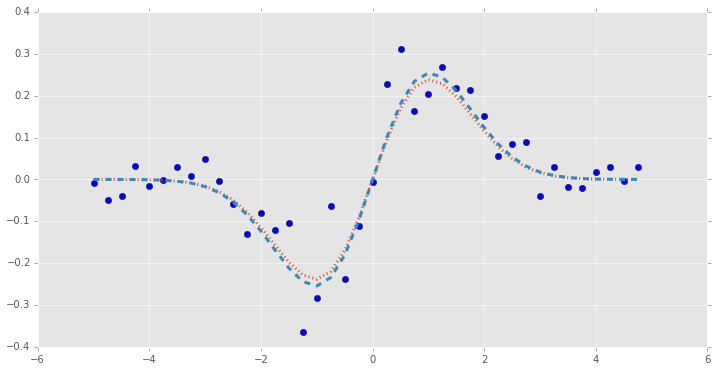

In [7]:
## Use same input data as above for direct comparison
ydata = ydataOrigNoisy
result = fitDipole(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole2, verbose=True)
plt.plot(xdata, ydata[:len(xdata)], 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit[:len(xdata)], linewidth=3, linestyle='dashed')
plt.show()

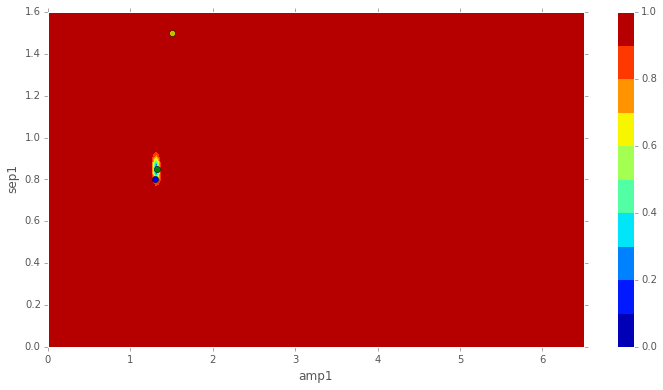

In [8]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, 
                                     limits=((0.,np.max([6.5,result.params['amp1'].value])), 
                                             (0., np.max([1.6,result.params['sep1'].value]))))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1')
plt.colorbar()
plt.ylabel('sep1')
plt.plot(1.3, 0.8, 'bo') ## input params
plt.plot(1.5, 1.5, 'yo') ## starting params
plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go')  ## fitted params

### This above weights the 3 planes equally. Let's weight the dipole plane 20x higher and see how it looks:

In [9]:
def fitDipole2(ydata, xdata, amp1Start=3., sep1Start=2., fitFunc=gen_dipole, verbose=False):
    gmod = lmfit.Model(fitFunc, verbose=verbose)
    weights = np.ones_like(ydata)
    weights[:len(xdata)] = 20.
    result = gmod.fit(ydata, x=xdata, weights=weights, amp1=amp1Start, sep1=sep1Start, verbose=verbose)

    if verbose: 
        print(result.fit_report(show_correl=False))
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    return result

 - Adding parameter "sep1"
 - Adding parameter "amp1"
[[Model]]
    Model(gen_dipole2)
[[Fit Statistics]]
    # function evals   = 19
    # data points      = 120
    # variables        = 2
    chi-square         = 53.747
    reduced chi-square = 0.455
[[Variables]]
    sep1:   0.77162927 +/- 0.228837 (29.66%) (init= 1.5)
    amp1:   1.43090240 +/- 0.390533 (27.29%) (init= 1.5)

         99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 sep1:  -0.37574  -0.28932  -0.17136   0.77163  +0.23711  +0.51305  +0.79572
 amp1:  -0.66351  -0.52294  -0.30935   1.43090  +0.37801  +0.79217  +1.24541


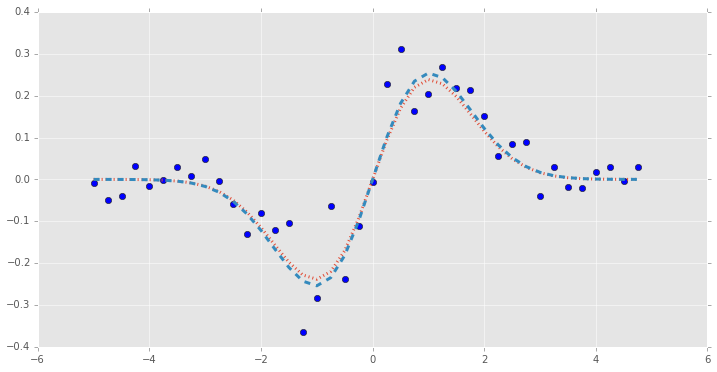

In [10]:
ydata = ydataOrigNoisy
result = fitDipole2(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole2, verbose=True)
plt.plot(xdata, ydata[:len(xdata)], 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit[:len(xdata)], linewidth=3, linestyle='dashed')
plt.show()

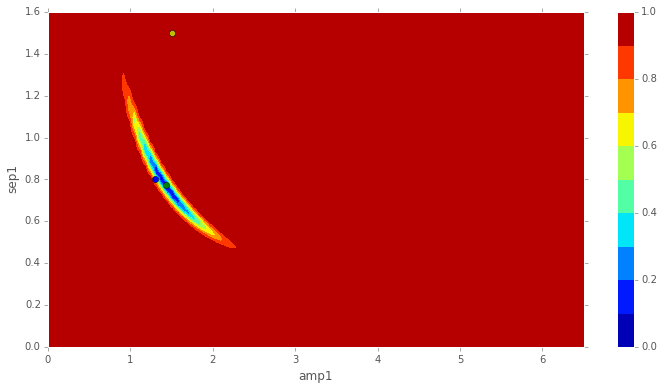

In [11]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, 
                                     limits=((0.,np.max([6.5,result.params['amp1'].value])), 
                                             (0., np.max([1.6,result.params['sep1'].value]))))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1')
plt.colorbar()
plt.ylabel('sep1')
plt.plot(1.3, 0.8, 'bo') ## input params
plt.plot(1.5, 1.5, 'yo') ## starting params
plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go')  ## fitted params